In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

In [2]:
# Possible estimators

# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
# Random Forest
# model setup: rf = RandomForestRegressor(n_estimators = 500, random_state = 18)
# training RF: rf.fit(X_pre, Y_pre)
# predict with RF: prediction = rf.predict(X_t)

# XGBoost
# model setup: xgb = XGBRegressor(n_estimators=300,random_state=0)
# training XGBoost: xgb.fit(X_pre,Y_pre)
#prediction with XGBoost: xgb.predict(X_t)


In [3]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t):
    # est_type: "NN1": 1-layer NN; "NN2": 2-layer NN; "rf": random forest; "gb": gradient boosting
    # (X_pre,Y_pre): training data
    # X_opt,X_adj,X_t: data used to predict
    # output: mean estimator m and the predictions m(X)
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state = 0,criterion='mse')
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "squared_error")
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
        

In [4]:
# train quantile estimator that estimate quantile for Y|X

# quantile loss for NN
def quantile_loss(preds, target, quantile):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    errors = target - preds
    q = quantile
    losses = torch.max((q - 1) * errors, q * errors)
    loss = torch.sum(losses)
    return loss

def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    # est_type: "NN1": 1-layer NN; "NN2": 2-layer NN; "qrf": quantile regression forest; "gb": gradient boostin
    # quantile: the quantile we are estimating
    # (X_pre,Y_pre): training data
    # X_opt,X_adj,X_t: data used to predict
    # output: quantile estimator Q and the prediction Q(X)
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state = 0)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t

In [5]:
# solve RKHS optimization problem
def RKHS_opt(K, Y):
    n = K.shape[0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(Y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB @ K.T)), constraints)
    prob.solve()
    return hB.value

In [6]:
# Solving the optimization problem
def solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t,
              function_class, E_opt=None, E_adj=None, E_t=None, degree = None,sigma = None):
    # M_opt: mean estimator m(X_opt)
    # function_class: "aug": Augmentation, "rkhs_poly": RKHS with polynomial kernel, "rkhs_rbf": RKHS with RBF kernel
    # E_opt: if function_class = "aug", then E is the estimator matrix, i.e. (E_opt)_{ij} = f_i((X_opt)_j)
    # degree: if function_class = "rkhs_poly", then set the degree of the polynomial
    # sigma: if function_class = "rkhs_rbf", then set parameter sigma
    # (X_opt,Y_opt): data used to solve the optimization problem
    # output: estimator for 100% coverage V_adj and V_t
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_t = X_t.shape[0]
    Y = (Y_opt-M_opt)[:,0]
        
    if function_class == "aug":
        cons_opt = np.ones(n_opt).reshape(1,-1)
        A_opt = np.vstack((E_opt,cons_opt))
        weight = cp.Variable(A_opt.shape[0])
        constraints = [weight>=0]+[weight @ A_opt >= cp.square(Y)]
        prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_opt)), constraints)
        prob.solve()
        optimal_weight = weight.value
        
        cons_adj = np.ones(n_adj).reshape(1,-1)
        A_adj = np.vstack((E_adj,cons_adj))
        V_adj = optimal_weight @ A_adj
        V_adj = V_adj.reshape(-1,1)
        
        cons_t = np.ones(n_t).reshape(1,-1)
        A_t = np.vstack((E_t,cons_t))
        V_t = optimal_weight @ A_t
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t
    
    if function_class == "rkhs_poly":
        X_inner_prod = X_opt @ X_opt.T
        K = np.power(1 + X_inner_prod, degree)
        hB = RKHS_opt(K,Y)
        
        X_inner_prod_adj = X_adj @ X_opt.T
        K_adj = np.power(1 + X_inner_prod_adj, degree)
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        X_inner_prod_t = X_t @ X_opt.T
        K_t = np.power(1 + X_inner_prod_t, degree)
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t
    
    if function_class == "rkhs_rbf":
        X_diff = np.power(X_opt @ np.ones((n_opt, 1)).T - np.ones((n_opt, 1)) @ X_opt.T, 2)
        K = np.exp(-(1 / (2 * sigma)) * X_diff)
        hB = RKHS_opt(K,Y)
        
        X_diff_adj = np.power(X_adj @ np.ones((n_opt, 1)).T - np.ones((n_adj, 1)) @ X_opt.T, 2)
        K_adj = np.exp(-(1 / (2 * sigma)) * X_diff_adj)
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        X_diff_t = np.power(X_t @ np.ones((n_opt, 1)).T - np.ones((n_t, 1)) @ X_opt.T, 2)
        K_t = np.exp(-(1 / (2 * sigma)) * X_diff_t)
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t
    

In [7]:
# Interval adjustment
def interval_adj(X_adj,Y_adj,M_adj,V_adj,alpha, stepsize=0.01,eps=0):
    # (X_adj,Y_adj): data used to adjust the interval
    # M_adj: mean estimator m(X_adj)
    # V_adj: variance estimator for 100% coverage f(X_adj)
    # alpha: get 1-alpha coverage
    # eps: extend the interval a bit 1/sqrt{log(n_opt)}
    # output: adjustment level delta
    # the prediction level is: [M-sqrt{delta V}, M+sqrt{delta V}]
    I = np.where(V_adj+eps-np.square(Y_adj-M_adj)>=0)[0]
    I.tolist()
    X_adj = X_adj[I].reshape(-1,1)
    Y_adj = Y_adj[I].reshape(-1,1)
    M_adj = M_adj[I].reshape(-1,1)
    V_adj = (V_adj[I]+eps).reshape(-1,1)
    delta = 1
    prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    while prop_outside <= alpha:
        delta = delta-stepsize
        prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    return delta

In [8]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t):
    # (X_t,Y_t): test data
    # M_t: mean estimator m(X_t)
    # V_t: variance estimator f(X_t)
    # The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]

    plt.plot(X_sort, Y_sort, 'o')
    plt.plot(X_sort, lower_CI_sort, '--r', lw=2)
    plt.plot(X_sort, upper_CI_sort, '--r', lw=2)
    plt.plot(X_sort, mean, '-m', lw=2)
    plt.show()
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

In [9]:
# read the data
data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)

# training data
index_1927 = data["Year"].to_list().index(1927)

MKT_t = MKT[index_1927:,:]
SMB_t = SMB[index_1927:,:]
HML_t = HML[index_1927:,:]
RF_t = RF[index_1927:,:]

# testing data
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_t =(MKT_t-np.mean(MKT_t))/np.std(MKT_t)
SMB_t =(SMB_t-np.mean(SMB_t))/np.std(SMB_t)
HML_t =(HML_t-np.mean(HML_t))/np.std(HML_t)
RF_t =(RF_t-np.mean(RF_t))/np.std(RF_t)

MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

# testing using data from 1927-01 to 2022-12
index_192701 = data["Year"].to_list().index(192701)
index_202212 = data["Year"].to_list().index(202212)
MKT_te = np.repeat(MKT_t, 12).reshape(-1,1) # use yearly MKT as x for testing data
#MKT_te = MKT_te[index_192701:index_202112+1,:]
SMB_te = SMB_te[index_192701:index_202212+1,:]
HML_te = HML_te[index_192701:index_202212+1,:]
RF_te = RF_te[index_192701:index_202212+1,:]

In [10]:
# We set x = MKT, y = HML
X_pre = MKT_t
Y_pre = HML_t
X_opt = X_pre[0:60,:]
Y_opt = Y_pre[0:60,:]
X_adj = X_pre[60:,:]
Y_adj = Y_pre[60:,:] #split the data to training set and calibration set
X_t = MKT_te
Y_t = HML_te

n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

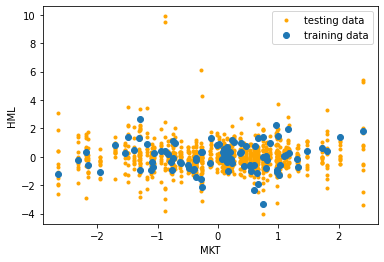

In [11]:
# plot training and testing data
plt.plot(X_t,Y_t,'.',color = 'orange', label = 'testing data')
plt.plot(X_pre,Y_pre,'o', label = 'training data')
plt.xlabel('MKT')
plt.ylabel('HML')
plt.legend(loc="upper right")
plt.show()

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


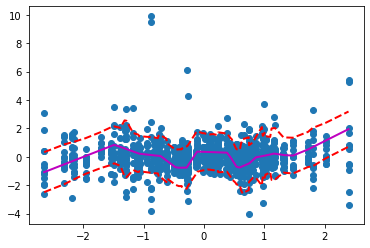

The overall coverage is 0.8845486111111112
The mean bandwidth for testing data is 1.967792092993123


In [12]:
# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    mdoel, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2))
E_t = E_t.T

# solve optimization problem

V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t)